# Continuous Control with DDPG and Reacher - Training Code
____________

## Imports

In [1]:
import copy
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from unityagents import UnityEnvironment
from collections import namedtuple, deque

## Set Up Environment and Key Variables

In [2]:
### Set the path to Unity Reacher Environment Executable
env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe')

### Extract brain_name, action size and state size
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state_size = env_info.vector_observations.shape[1]

### Pick which device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## Hyperparameters

In [3]:
BUFFER_SIZE = int(3e6)     # replay buffer size
BATCH_SIZE = 1024          # minibatch size
GAMMA = 0.99               # discount factor
TAU = 1e-3                 # for soft update of target parameters
LR_ACTOR = 1e-4            # learning rate of the actor 
LR_CRITIC = 2e-4           # learning rate of the critic
update_every = 20          # number of timesteps after which to run an update
SN = 0.25                  # starting value for additive noise scale (exploratory actions)
ND = 0.99999               # noise decay rate (exploratory actions)
NM = 0.01                  # noise minimum to be maintained (exploratory actions)

## DDPG Agent & Methods
______________________

### Define Actor and Critic network architectures

In [4]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size, hu=(400, 300), activ_in = F.relu, activ_out = torch.tanh):
        super(Actor, self).__init__()
        
        self.activ_in = activ_in
        self.activ_out = activ_out
        
        self.input_layer = nn.Linear(state_size, hu[0])
        self.hl1 = nn.Linear(hu[0], hu[1])
        self.output_layer = nn.Linear(hu[-1], action_size)
        
    def forward(self, state):
        x = state
        x = self.activ_in(self.input_layer(x))
        x = self.activ_in(self.hl1(x))
        return self.activ_out(self.output_layer(x))  
    
class Critic(nn.Module):
    def __init__(self, state_size, action_size, hu=(400, 300), activ_in = F.relu):
        super(Critic, self).__init__()
        
        self.activ_in = activ_in
        
        self.input_layer = nn.Linear(state_size, hu[0])
        self.hl1 = nn.Linear(hu[0]+action_size, hu[1])        
        self.output_layer = nn.Linear(hu[-1], 1)
        
    def forward(self, state, action):
        x = state
        u = action
        
        x = self.activ_in(self.input_layer(x))
        x = torch.cat((x, u), dim=1)
        x = self.activ_in(self.hl1(x))
        return self.output_layer(x)

### Define Agent class and its methods

In [5]:
class Agent():
    def __init__(self, state_size, action_size, start_noise=SN, noise_decay=ND, noise_min=NM, add_noise=True):
        self.state_size = state_size
        self.action_size = action_size
        
        ### Initialise actor online and target networks
        self.actor_online = Actor(state_size, action_size).to(device)
        self.actor_target = Actor(state_size, action_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_online.parameters(), lr=LR_ACTOR)
        
        ### Initialise critic online and target networks
        self.critic_online = Critic(state_size, action_size).to(device)
        self.critic_target = Critic(state_size, action_size).to(device)
        self.critic_optimizer = optim.Adam(self.critic_online.parameters(), lr=LR_CRITIC)
        
        
        ### Noise parameters for exploration
        self.noise_scale = start_noise
        self.noise_decay = noise_decay
        self.noise_min = noise_min
        
        self.add_noise = add_noise
        
        ### Replay buffer
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE)
        
        ### Keep track of timesteps since last training update
        self.update = 0
    
    ### Generate random normal noise to add to the action output and enable exploration
    def generate_noise(self):
        noise = np.random.normal(loc=0, scale=self.noise_scale, size=self.action_size)
        self.noise_scale = max(self.noise_decay*self.noise_scale, self.noise_min)
        return noise
    
    ### Store experiences in the replay buffer and control training updates
    def step(self, state, action, reward, next_state, done, update_cycles=3):
        # Commit experience to memory
        self.memory.add(state, action, reward, next_state, done)
        self.update = (self.update +1)%update_every
        
        # Run optimisation 'update_cycles' times
        c=0
        if (self.update==0):
            if len(self.memory) > BATCH_SIZE:
                while c < update_cycles:
                    experiences = self.memory.sample()
                    self.learn(experiences, GAMMA)
                    c+=1
    
    ### Use the actor network to select an action. OPTIONAL: add noise to the action (add_noise=True)
    def act(self, state):
        state = torch.from_numpy(state).float().to(device)
        self.actor_online.eval()
        with torch.no_grad():
            action = self.actor_online(state).cpu().data.numpy()
        self.actor_online.train()
        if self.add_noise:
            action += self.generate_noise()
        return np.clip(action, -1, 1)
    
    ### Run a training update from a batch of experiences on the critic and actor online networks and a 
    ## soft update on the respective target networks
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        
        ### Update critic
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        Q_targets = rewards + (gamma * Q_targets_next * (1-dones))
        Q_expected = self.critic_online(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        # Backprop
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_online.parameters(), 1)
        self.critic_optimizer.step()
        
        
        ### Update actor
        actions_pred = self.actor_online(states)
        actor_loss = -self.critic_online(states, actions_pred).mean()
        
        # Backprop
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor_online.parameters(), 1)
        self.actor_optimizer.step()
        
        
        ### Update targets
        self.soft_update(self.critic_online, self.critic_target, TAU)
        self.soft_update(self.actor_online, self.actor_target, TAU)
    
    ### Blend together online and target network parameters
    def soft_update(self, online_model, target_model, tau):
        for target_param, online_param in zip(target_model.parameters(), online_model.parameters()):
            target_param.data.copy_(tau*online_param.data + (1.0-tau)*target_param.data)
            
### Define a Replaybuffer class to store experiences, organise and sample from them
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    ### Adds an experience tuple to memory
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    ### Samples k (batch size) experience tuples randomly from memory
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        return len(self.memory)

### Training function

In [6]:
### Train a DDPG agent, monitor score and save Actor/Critic checkpoints if task solved.
def ddpg(output, n_episodes=1000, max_t=1000):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]           # reset the environment 
        state = env_info.vector_observations[0]                     # get the current state
        score = 0                                                   # initialize the score
        for t in range(max_t):
            action = agent.act(state)                               # select an action
            env_info = env.step(action)[brain_name]                 # send action to tne environment
            next_state = env_info.vector_observations[0]            # get next state
            reward = env_info.rewards[0]                            # get reward
            done = env_info.local_done[0]                           # check if episode finished
            agent.step(state, action, reward, next_state, done)     # agent takes one step to train
            state = next_state                                      # roll over state to next time step
            score += reward                                         # update the score
            if done:                                                # exit loop if episode finished
                break 
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), score), end="")
        if np.mean(scores_deque)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            torch.save(agent.actor_online.state_dict(), '{}_checkpoint_actor.pth'.format(output))
            torch.save(agent.critic_online.state_dict(), '{}_checkpoint_critic.pth'.format(output))
            break
            
    return scores

### Watch a naive agent perform the task

In [8]:
agent = Agent(state_size, action_size)
env_info = env.reset(train_mode=False)[brain_name]   
state = env_info.vector_observations                 
score = 0                                            
agent.add_noise = False
for i in range(150):
    action = agent.act(state)                        
    env_info = env.step(action)[brain_name]           
    next_state = env_info.vector_observations[0]      
    reward = env_info.rewards[0]                     
    done = env_info.local_done[0]                   
    score += env_info.rewards[0]                      
    state = next_state                               
    if done:                                          
        break
print('Total score this episode: {:.2f}'.format(score))
agent.add_noise = True

Total score this episode: 0.00


### Run the cell below to re-initialise and train the agent 
When calling ```ddpg``` add arguments for ```output``` (file name for checkpoint if solved) and ```n_episodes=1000``` to train for if you wish.

In [9]:
agent = Agent(state_size, action_size)
scores = ddpg(output='01.04.2020_1')

Episode 465	Average Score: 30.04	Score: 39.51
Environment solved in 365 episodes!	Average Score: 30.04


### Plot results

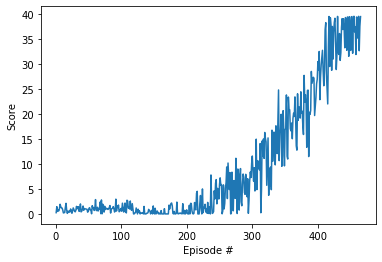

<Figure size 432x288 with 0 Axes>

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Watch a trained agent perform the task

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]   
state = env_info.vector_observations               
score = 0                                           
agent.add_noise = False
for i in range(1000):
    action = agent.act(state)                        
    env_info = env.step(action)[brain_name]          
    next_state = env_info.vector_observations[0]      
    reward = env_info.rewards[0]                     
    done = env_info.local_done[0]                     
    score += env_info.rewards[0]                      
    state = next_state                               
    if done:                                         
        break
print('Total score this episode: {:.2f}'.format(score))
agent.add_noise = True